In [1]:
%matplotlib inline
import sys
import random
import operator
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, metrics, ensemble, neighbors, linear_model, tree, model_selection
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import TruncatedSVD


import matplotlib.pyplot as plt

/home/dj/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dj/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.4 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train=pd.read_csv('data/criminal_train.csv')
test=pd.read_csv('data/criminal_test.csv')

In [3]:
train.head()

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,Criminal
0,25095143,4,2,4,1,3,1,1,1,99,...,1,2,1,1,2,2,3884.805998,40026,1,0
1,13005143,4,1,3,1,2,1,1,1,99,...,2,2,2,3,2,2,1627.108106,40015,2,1
2,67415143,4,1,2,1,2,1,1,1,99,...,2,2,2,3,2,2,4344.957980,40024,1,0
3,70925143,4,0,2,1,1,1,1,1,99,...,2,2,1,1,2,2,792.521931,40027,1,0
4,75235143,1,0,6,1,4,1,1,1,99,...,2,2,2,2,2,2,1518.118526,40001,2,0


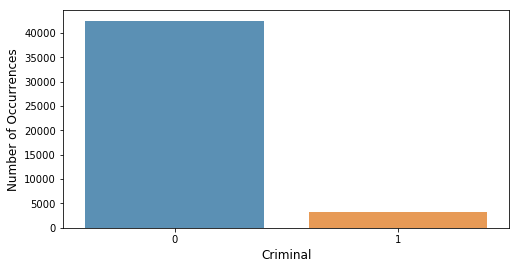

In [4]:
cnt_srs = train['Criminal'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Criminal', fontsize=12)

In [94]:
train_X=train.drop(['PERID', 'Criminal'], 1)
test_X=test.drop(['PERID'], 1)
train_y=train['Criminal']

In [22]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, feature_names=None, seed_val=0, rounds=500, dep=5, eta=0.1):
    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = 'auc'
    params["eta"] = eta
    params["subsample"] = 1
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = dep
    params["silent"] = 1
    params["seed"] = seed_val
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names)
        model.dump_model('xgbmodel.txt', 'xgb.fmap', with_stats=True)
        importance = model.get_fscore(fmap='xgb.fmap')
        importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv("imp_feat.txt", index=False)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    pred_test_y2 = model.predict(xgb.DMatrix(test_X2), ntree_limit=model.best_ntree_limit)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        return pred_test_y, loss, pred_test_y2
    else:
        return pred_test_y, loss, pred_test_y2

In [23]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = dep
    params["min_data_in_leaf"] = 128
    params["learning_rate"] = eta
    params["bagging_fraction"] = 1
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed_val
    params["verbosity"] = 0
    num_rounds = rounds

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=100, verbose_eval=20)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return pred_test_y, loss, pred_test_y2
    else:
        return pred_test_y, loss, pred_test_y2

In [103]:
def runRF(train_X, train_y, test_X, test_y=None, test_X2=None, depth=10, leaf=5, feat=0.7):
    model = RandomForestClassifier(n_estimators = 500,
                                   criterion = 'gini',
                                   max_depth = depth,
                                   min_samples_split = 2,
                                   min_samples_leaf = leaf,
                                   max_features =  feat,
                                   n_jobs = -1,
                                   #class_weight = 'balanced',
                                   random_state = 0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]   
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth, leaf, feat : ", depth, leaf, feat)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [25]:
def runET(train_X, train_y, test_X, test_y=None, test_X2=None, depth=10, leaf=5, feat=0.7):
    model = ensemble.ExtraTreesClassifier(
                                        n_estimators = 500,
                                        criterion = 'gini',
                                        max_depth = depth,
                                        min_samples_split = 10,
                                        min_samples_leaf = leaf,
                                        max_features =  feat,
                                        #min_impurity_split = 0.1,
                                        n_jobs = -1,
                                        random_state = 0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth, leaf, feat : ", depth, leaf, feat)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [26]:
def runGBM(train_X, train_y, test_X, test_y=None, test_X2=None, depth=6, leaf=5, feat=0.7):
    model = GradientBoostingClassifier(n_estimators=3000,
                                       learning_rate=0.05,
                                       max_depth=depth,
                                       max_features=feat,
                                       min_samples_leaf=leaf,
                                       random_state=0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]   
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth, leaf, feat : ", depth, leaf, feat)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [36]:
def runCatB(train_X, train_y, test_X, test_y=None, test_X2=None, depth=6):
    model = CatBoostClassifier(
                                iterations = 500,
                                learning_rate = 0.05,
                                depth = depth,
                                od_type='Iter',
                                od_wait=100,
                                l2_leaf_reg=6,
                                eval_metric = 'AUC', 
                                verbose=False,
                                random_seed=0)
    
    model.fit(train_X, train_y, eval_set=(test_X, test_y))#, plot=True)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth : ", depth)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [28]:
def runADA(train_X, train_y, test_X, test_y=None, test_X2=None, depth=4):
    model = AdaBoostClassifier(
                                DecisionTreeClassifier(max_depth=depth, max_features=0.7, min_samples_leaf=5),
                                n_estimators = 20,
                                learning_rate = 0.05,
                                random_state=0)
    
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth : ", depth)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [29]:
results = pd.DataFrame(index=range(7), columns=['Model', 'AUC Score'])
k=0
col=[]
val_pred=pd.DataFrame()
test_pred=pd.DataFrame()
for model_name in ['XGB', 'LGM', 'RF', 'ET', 'GBM', 'CatBoost', 'ADA']:
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = []
    pred_test_full = 0
    pred_val_full = np.zeros(train_X.shape[0])
    for dev_index, val_index in kf.split(train_X):
        dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]

        if model_name=='XGB':
            pred_val, loss, pred_test = runXGB(dev_X, dev_y, val_X, val_y, test_X, rounds=5000, feature_names=dev_X.columns.tolist())
        elif model_name=='LGM':
            pred_val, loss, pred_test = runLGB(dev_X, dev_y, val_X, val_y, test_X, rounds=5000)
        elif model_name=='RF':
            pred_val, loss, pred_test = runRF(dev_X, dev_y, val_X, val_y, test_X)
        elif model_name=='ET':
            pred_val, loss, pred_test = runET(dev_X, dev_y, val_X, val_y, test_X)
        elif model_name=='GBM':
            pred_val, loss, pred_test = runGBM(dev_X, dev_y, val_X, val_y, test_X)    
        elif model_name=='CatBoost':
            pred_val, loss, pred_test = runCatB(dev_X, dev_y, val_X, val_y, test_X)
        elif model_name=='ADA':
            pred_val, loss, pred_test = runADA(dev_X, dev_y, val_X, val_y, test_X)
            
        pred_val_full[val_index] = pred_val
        pred_test_full = pred_test_full + pred_test
        cv_scores.append(loss)
        print(cv_scores)
    pred_test_full /= 5.
    col.append(model_name)
    val_pred=pd.concat([val_pred, pd.DataFrame(pred_val_full)], axis=1)
    test_pred=pd.concat([test_pred, pd.DataFrame(pred_test_full)], axis=1)
    val_pred.columns=col
    test_pred.columns=col
    print(metrics.roc_auc_score(train_y, pred_val_full))
    results['Model'][k]=model_name
    results['AUC Score'][k]=metrics.roc_auc_score(train_y, pred_val_full)
    k=k+1

[0]	train-auc:0.96164	test-auc:0.960158
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.974059	test-auc:0.970838
[40]	train-auc:0.97502	test-auc:0.971235
[60]	train-auc:0.975884	test-auc:0.971353
[80]	train-auc:0.976826	test-auc:0.971292
[100]	train-auc:0.978086	test-auc:0.971162
[120]	train-auc:0.97909	test-auc:0.971222
[140]	train-auc:0.980026	test-auc:0.971218
[160]	train-auc:0.9809	test-auc:0.971291
Stopping. Best iteration:
[63]	train-auc:0.976046	test-auc:0.971395

[0.97139496340804843]
[0]	train-auc:0.959063	test-auc:0.963269
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.972569	test-auc:0.97694
[40]	train-auc:0.97353	test-auc:0.977197
[60]	train-auc:0.974484	test-auc:0.977005
[80]	train-auc:0.975358	test-auc:0.976919
[100]	train-auc:0.976652	test-auc:0.976683

/home/dj/anaconda3/lib/python3.6/site-packages/catboost/core.py:1240: FutureWarning: The 'verbose' parameter is deprecated, use 'logging_level' parameter instead (posible values: 'Silent', 'Verbose', 'Info', 'Debug').
  super(CatBoostClassifier, self).__init__(params)


0: learn: 0.9490759	test: 0.9439244	bestTest: 0.9439244 (0)	total: 279ms	remaining: 2m 19s
1: learn: 0.9593499	test: 0.9564685	bestTest: 0.9564685 (1)	total: 490ms	remaining: 2m 1s
2: learn: 0.9615003	test: 0.9577192	bestTest: 0.9577192 (2)	total: 722ms	remaining: 1m 59s
3: learn: 0.9601727	test: 0.9558553	bestTest: 0.9577192 (2)	total: 956ms	remaining: 1m 58s
4: learn: 0.9625012	test: 0.9574261	bestTest: 0.9577192 (2)	total: 1.19s	remaining: 1m 57s
5: learn: 0.9645241	test: 0.9607362	bestTest: 0.9607362 (5)	total: 1.41s	remaining: 1m 56s
6: learn: 0.9662395	test: 0.9625019	bestTest: 0.9625019 (6)	total: 1.63s	remaining: 1m 54s
7: learn: 0.9675176	test: 0.963951	bestTest: 0.963951 (7)	total: 1.83s	remaining: 1m 52s
8: learn: 0.967505	test: 0.9635462	bestTest: 0.963951 (7)	total: 2.11s	remaining: 1m 54s
9: learn: 0.96834	test: 0.9643421	bestTest: 0.9643421 (9)	total: 2.3s	remaining: 1m 52s
10: learn: 0.9698232	test: 0.9659038	bestTest: 0.9659038 (10)	total: 2.52s	remaining: 1m 51s
11: l

89: learn: 0.97466	test: 0.9703355	bestTest: 0.9704057 (75)	total: 22.3s	remaining: 1m 41s
90: learn: 0.9746729	test: 0.9703262	bestTest: 0.9704057 (75)	total: 22.5s	remaining: 1m 41s
91: learn: 0.974674	test: 0.9703195	bestTest: 0.9704057 (75)	total: 22.7s	remaining: 1m 40s
92: learn: 0.974707	test: 0.9703404	bestTest: 0.9704057 (75)	total: 23s	remaining: 1m 40s
93: learn: 0.9747545	test: 0.9703426	bestTest: 0.9704057 (75)	total: 23.2s	remaining: 1m 40s
94: learn: 0.9747711	test: 0.9703458	bestTest: 0.9704057 (75)	total: 23.8s	remaining: 1m 41s
95: learn: 0.9747767	test: 0.9703356	bestTest: 0.9704057 (75)	total: 24.1s	remaining: 1m 41s
96: learn: 0.9747952	test: 0.9703441	bestTest: 0.9704057 (75)	total: 24.3s	remaining: 1m 40s
97: learn: 0.9748062	test: 0.9703409	bestTest: 0.9704057 (75)	total: 24.6s	remaining: 1m 40s
98: learn: 0.9748166	test: 0.9703492	bestTest: 0.9704057 (75)	total: 24.8s	remaining: 1m 40s
99: learn: 0.9748264	test: 0.9703391	bestTest: 0.9704057 (75)	total: 25.1s	r

176: learn: 0.9760962	test: 0.9706209	bestTest: 0.9706612 (159)	total: 46.5s	remaining: 1m 24s
177: learn: 0.976143	test: 0.9706092	bestTest: 0.9706612 (159)	total: 46.8s	remaining: 1m 24s
178: learn: 0.9761519	test: 0.9706067	bestTest: 0.9706612 (159)	total: 47.2s	remaining: 1m 24s
179: learn: 0.9761961	test: 0.9706195	bestTest: 0.9706612 (159)	total: 47.5s	remaining: 1m 24s
180: learn: 0.9762006	test: 0.9706165	bestTest: 0.9706612 (159)	total: 47.7s	remaining: 1m 24s
181: learn: 0.9762138	test: 0.9706168	bestTest: 0.9706612 (159)	total: 48s	remaining: 1m 23s
182: learn: 0.9762565	test: 0.9706165	bestTest: 0.9706612 (159)	total: 48.4s	remaining: 1m 23s
183: learn: 0.9762728	test: 0.9706129	bestTest: 0.9706612 (159)	total: 48.7s	remaining: 1m 23s
184: learn: 0.9762823	test: 0.9706044	bestTest: 0.9706612 (159)	total: 49s	remaining: 1m 23s
185: learn: 0.9762887	test: 0.9706099	bestTest: 0.9706612 (159)	total: 49.3s	remaining: 1m 23s
186: learn: 0.9763011	test: 0.9706122	bestTest: 0.97066

263: learn: 0.977472	test: 0.970978	bestTest: 0.9709906 (260)	total: 1m 11s	remaining: 1m 4s
264: learn: 0.9774876	test: 0.9709801	bestTest: 0.9709906 (260)	total: 1m 12s	remaining: 1m 3s
265: learn: 0.9774897	test: 0.9709784	bestTest: 0.9709906 (260)	total: 1m 12s	remaining: 1m 3s
266: learn: 0.9775266	test: 0.9709851	bestTest: 0.9709906 (260)	total: 1m 12s	remaining: 1m 3s
267: learn: 0.9775278	test: 0.970994	bestTest: 0.970994 (267)	total: 1m 12s	remaining: 1m 3s
268: learn: 0.977556	test: 0.9710133	bestTest: 0.9710133 (268)	total: 1m 13s	remaining: 1m 2s
269: learn: 0.977562	test: 0.9710181	bestTest: 0.9710181 (269)	total: 1m 13s	remaining: 1m 2s
270: learn: 0.9775784	test: 0.9710346	bestTest: 0.9710346 (270)	total: 1m 14s	remaining: 1m 2s
271: learn: 0.9775968	test: 0.9710399	bestTest: 0.9710399 (271)	total: 1m 14s	remaining: 1m 2s
272: learn: 0.9776088	test: 0.9710349	bestTest: 0.9710399 (271)	total: 1m 14s	remaining: 1m 2s
273: learn: 0.9776304	test: 0.9710472	bestTest: 0.971047

350: learn: 0.9787642	test: 0.9712647	bestTest: 0.9712647 (350)	total: 1m 36s	remaining: 41s
351: learn: 0.9787858	test: 0.971258	bestTest: 0.9712647 (350)	total: 1m 36s	remaining: 40.8s
352: learn: 0.9788204	test: 0.9712376	bestTest: 0.9712647 (350)	total: 1m 37s	remaining: 40.5s
353: learn: 0.9788423	test: 0.9712468	bestTest: 0.9712647 (350)	total: 1m 37s	remaining: 40.3s
354: learn: 0.9788797	test: 0.9712447	bestTest: 0.9712647 (350)	total: 1m 37s	remaining: 40s
355: learn: 0.9788967	test: 0.9712448	bestTest: 0.9712647 (350)	total: 1m 38s	remaining: 39.7s
356: learn: 0.978902	test: 0.9712477	bestTest: 0.9712647 (350)	total: 1m 38s	remaining: 39.4s
357: learn: 0.9789314	test: 0.9712677	bestTest: 0.9712677 (357)	total: 1m 38s	remaining: 39.1s
358: learn: 0.9789341	test: 0.9712541	bestTest: 0.9712677 (357)	total: 1m 38s	remaining: 38.8s
359: learn: 0.9789474	test: 0.9712549	bestTest: 0.9712677 (357)	total: 1m 39s	remaining: 38.5s
360: learn: 0.9789491	test: 0.9712603	bestTest: 0.971267

437: learn: 0.9798529	test: 0.9712713	bestTest: 0.9713418 (419)	total: 2m	remaining: 17.1s
438: learn: 0.9798564	test: 0.971267	bestTest: 0.9713418 (419)	total: 2m 1s	remaining: 16.8s
439: learn: 0.9798862	test: 0.9712613	bestTest: 0.9713418 (419)	total: 2m 1s	remaining: 16.6s
440: learn: 0.9798991	test: 0.9712626	bestTest: 0.9713418 (419)	total: 2m 1s	remaining: 16.3s
441: learn: 0.9799022	test: 0.9712617	bestTest: 0.9713418 (419)	total: 2m 2s	remaining: 16s
442: learn: 0.9799217	test: 0.9712576	bestTest: 0.9713418 (419)	total: 2m 2s	remaining: 15.7s
443: learn: 0.979927	test: 0.9712519	bestTest: 0.9713418 (419)	total: 2m 2s	remaining: 15.5s
444: learn: 0.9799355	test: 0.9712503	bestTest: 0.9713418 (419)	total: 2m 3s	remaining: 15.2s
445: learn: 0.9799417	test: 0.9712498	bestTest: 0.9713418 (419)	total: 2m 3s	remaining: 14.9s
446: learn: 0.9799545	test: 0.9712461	bestTest: 0.9713418 (419)	total: 2m 3s	remaining: 14.7s
447: learn: 0.9799711	test: 0.9712523	bestTest: 0.9713418 (419)	tot

24: learn: 0.9708318	test: 0.9753319	bestTest: 0.9753319 (24)	total: 6.4s	remaining: 2m 1s
25: learn: 0.9709948	test: 0.9754073	bestTest: 0.9754073 (25)	total: 6.59s	remaining: 2m
26: learn: 0.9711182	test: 0.9755872	bestTest: 0.9755872 (26)	total: 6.82s	remaining: 1m 59s
27: learn: 0.9711755	test: 0.9757492	bestTest: 0.9757492 (27)	total: 7.17s	remaining: 2m
28: learn: 0.9712811	test: 0.975979	bestTest: 0.975979 (28)	total: 7.34s	remaining: 1m 59s
29: learn: 0.9712573	test: 0.9759819	bestTest: 0.9759819 (29)	total: 7.55s	remaining: 1m 58s
30: learn: 0.9713165	test: 0.9761477	bestTest: 0.9761477 (30)	total: 7.78s	remaining: 1m 57s
31: learn: 0.9713213	test: 0.9761434	bestTest: 0.9761477 (30)	total: 8.05s	remaining: 1m 57s
32: learn: 0.9714405	test: 0.9761483	bestTest: 0.9761483 (32)	total: 8.3s	remaining: 1m 57s
33: learn: 0.9715011	test: 0.9761731	bestTest: 0.9761731 (33)	total: 8.64s	remaining: 1m 58s
34: learn: 0.9715021	test: 0.9761644	bestTest: 0.9761731 (33)	total: 8.98s	remainin

113: learn: 0.97374	test: 0.9767563	bestTest: 0.9767864 (94)	total: 30.7s	remaining: 1m 43s
114: learn: 0.9737441	test: 0.9767525	bestTest: 0.9767864 (94)	total: 31.1s	remaining: 1m 44s
115: learn: 0.973756	test: 0.9767632	bestTest: 0.9767864 (94)	total: 31.4s	remaining: 1m 44s
116: learn: 0.9737606	test: 0.976758	bestTest: 0.9767864 (94)	total: 31.8s	remaining: 1m 43s
117: learn: 0.9737644	test: 0.9767809	bestTest: 0.9767864 (94)	total: 32.1s	remaining: 1m 43s
118: learn: 0.9737667	test: 0.9767985	bestTest: 0.9767985 (118)	total: 32.5s	remaining: 1m 44s
119: learn: 0.9737743	test: 0.9768064	bestTest: 0.9768064 (119)	total: 33s	remaining: 1m 44s
120: learn: 0.9737773	test: 0.9767879	bestTest: 0.9768064 (119)	total: 33.4s	remaining: 1m 44s
121: learn: 0.9738088	test: 0.9768057	bestTest: 0.9768064 (119)	total: 33.8s	remaining: 1m 44s
122: learn: 0.9738289	test: 0.9767826	bestTest: 0.9768064 (119)	total: 34.1s	remaining: 1m 44s
123: learn: 0.9738506	test: 0.9767754	bestTest: 0.9768064 (11

200: learn: 0.9749452	test: 0.97685	bestTest: 0.976855 (199)	total: 57.5s	remaining: 1m 25s
201: learn: 0.9749656	test: 0.9768365	bestTest: 0.976855 (199)	total: 57.7s	remaining: 1m 25s
202: learn: 0.9749821	test: 0.9768328	bestTest: 0.976855 (199)	total: 57.9s	remaining: 1m 24s
203: learn: 0.9749991	test: 0.9768428	bestTest: 0.976855 (199)	total: 58.1s	remaining: 1m 24s
204: learn: 0.9750201	test: 0.9768569	bestTest: 0.9768569 (204)	total: 58.3s	remaining: 1m 23s
205: learn: 0.9750492	test: 0.9768441	bestTest: 0.9768569 (204)	total: 58.6s	remaining: 1m 23s
206: learn: 0.9750563	test: 0.9768401	bestTest: 0.9768569 (204)	total: 58.7s	remaining: 1m 23s
207: learn: 0.9750753	test: 0.9768547	bestTest: 0.9768569 (204)	total: 58.9s	remaining: 1m 22s
208: learn: 0.9750858	test: 0.9768543	bestTest: 0.9768569 (204)	total: 59.1s	remaining: 1m 22s
209: learn: 0.9751073	test: 0.9768468	bestTest: 0.9768569 (204)	total: 59.3s	remaining: 1m 21s
210: learn: 0.9751123	test: 0.9768638	bestTest: 0.976863

287: learn: 0.9765343	test: 0.9768932	bestTest: 0.9768932 (287)	total: 1m 18s	remaining: 57.9s
288: learn: 0.9765403	test: 0.9768963	bestTest: 0.9768963 (288)	total: 1m 18s	remaining: 57.6s
289: learn: 0.9765578	test: 0.9769024	bestTest: 0.9769024 (289)	total: 1m 19s	remaining: 57.3s
290: learn: 0.9765643	test: 0.9769144	bestTest: 0.9769144 (290)	total: 1m 19s	remaining: 57.1s
291: learn: 0.9765732	test: 0.9769207	bestTest: 0.9769207 (291)	total: 1m 19s	remaining: 56.7s
292: learn: 0.9765871	test: 0.9769265	bestTest: 0.9769265 (292)	total: 1m 19s	remaining: 56.4s
293: learn: 0.97662	test: 0.9769385	bestTest: 0.9769385 (293)	total: 1m 20s	remaining: 56.1s
294: learn: 0.9766258	test: 0.9769305	bestTest: 0.9769385 (293)	total: 1m 20s	remaining: 55.8s
295: learn: 0.9766425	test: 0.9769167	bestTest: 0.9769385 (293)	total: 1m 20s	remaining: 55.5s
296: learn: 0.9766736	test: 0.976917	bestTest: 0.9769385 (293)	total: 1m 20s	remaining: 55.2s
297: learn: 0.9766879	test: 0.9769331	bestTest: 0.976

374: learn: 0.9780131	test: 0.9768676	bestTest: 0.9769642 (307)	total: 1m 41s	remaining: 34s
375: learn: 0.9780424	test: 0.9768484	bestTest: 0.9769642 (307)	total: 1m 42s	remaining: 33.7s
376: learn: 0.9780713	test: 0.9768391	bestTest: 0.9769642 (307)	total: 1m 42s	remaining: 33.4s
377: learn: 0.9780906	test: 0.9768419	bestTest: 0.9769642 (307)	total: 1m 42s	remaining: 33.2s
378: learn: 0.9781135	test: 0.9768391	bestTest: 0.9769642 (307)	total: 1m 43s	remaining: 32.9s
379: learn: 0.978115	test: 0.9768384	bestTest: 0.9769642 (307)	total: 1m 43s	remaining: 32.6s
380: learn: 0.9781162	test: 0.9768406	bestTest: 0.9769642 (307)	total: 1m 43s	remaining: 32.4s
381: learn: 0.9781346	test: 0.9768517	bestTest: 0.9769642 (307)	total: 1m 43s	remaining: 32.1s
382: learn: 0.9781504	test: 0.9768467	bestTest: 0.9769642 (307)	total: 1m 44s	remaining: 31.8s
383: learn: 0.9781767	test: 0.9768386	bestTest: 0.9769642 (307)	total: 1m 44s	remaining: 31.5s
384: learn: 0.9781829	test: 0.9768452	bestTest: 0.976

140: learn: 0.9757166	test: 0.9699425	bestTest: 0.9700518 (97)	total: 39.8s	remaining: 1m 41s
141: learn: 0.9757368	test: 0.9699339	bestTest: 0.9700518 (97)	total: 40s	remaining: 1m 40s
142: learn: 0.9757698	test: 0.969937	bestTest: 0.9700518 (97)	total: 40.5s	remaining: 1m 41s
143: learn: 0.9757723	test: 0.9699428	bestTest: 0.9700518 (97)	total: 40.7s	remaining: 1m 40s
144: learn: 0.9757886	test: 0.9699609	bestTest: 0.9700518 (97)	total: 41s	remaining: 1m 40s
145: learn: 0.9757966	test: 0.9699454	bestTest: 0.9700518 (97)	total: 41.2s	remaining: 1m 39s
146: learn: 0.975797	test: 0.9699449	bestTest: 0.9700518 (97)	total: 41.7s	remaining: 1m 40s
147: learn: 0.9758142	test: 0.9699341	bestTest: 0.9700518 (97)	total: 41.9s	remaining: 1m 39s
148: learn: 0.9758246	test: 0.9699253	bestTest: 0.9700518 (97)	total: 42.2s	remaining: 1m 39s
149: learn: 0.9758337	test: 0.9699138	bestTest: 0.9700518 (97)	total: 42.4s	remaining: 1m 39s
150: learn: 0.9758447	test: 0.9699133	bestTest: 0.9700518 (97)	tot

27: learn: 0.9719129	test: 0.9702904	bestTest: 0.9703475 (26)	total: 8.23s	remaining: 2m 18s
28: learn: 0.9720385	test: 0.9704423	bestTest: 0.9704423 (28)	total: 8.44s	remaining: 2m 17s
29: learn: 0.9721058	test: 0.9704447	bestTest: 0.9704447 (29)	total: 8.78s	remaining: 2m 17s
30: learn: 0.9721516	test: 0.9704385	bestTest: 0.9704447 (29)	total: 9.05s	remaining: 2m 16s
31: learn: 0.9722076	test: 0.970497	bestTest: 0.970497 (31)	total: 9.38s	remaining: 2m 17s
32: learn: 0.9722181	test: 0.9705104	bestTest: 0.9705104 (32)	total: 9.59s	remaining: 2m 15s
33: learn: 0.9722497	test: 0.9705726	bestTest: 0.9705726 (33)	total: 9.85s	remaining: 2m 14s
34: learn: 0.972315	test: 0.9704225	bestTest: 0.9705726 (33)	total: 10.1s	remaining: 2m 13s
35: learn: 0.9723141	test: 0.9704243	bestTest: 0.9705726 (33)	total: 10.3s	remaining: 2m 12s
36: learn: 0.9723303	test: 0.9703288	bestTest: 0.9705726 (33)	total: 10.6s	remaining: 2m 12s
37: learn: 0.972346	test: 0.9703415	bestTest: 0.9705726 (33)	total: 10.8s

116: learn: 0.974808	test: 0.9718003	bestTest: 0.971806 (112)	total: 33.4s	remaining: 1m 49s
117: learn: 0.9748089	test: 0.9718008	bestTest: 0.971806 (112)	total: 33.6s	remaining: 1m 48s
118: learn: 0.9748255	test: 0.9718258	bestTest: 0.9718258 (118)	total: 33.9s	remaining: 1m 48s
119: learn: 0.9748266	test: 0.9718264	bestTest: 0.9718264 (119)	total: 34.1s	remaining: 1m 48s
120: learn: 0.9748504	test: 0.9718349	bestTest: 0.9718349 (120)	total: 34.3s	remaining: 1m 47s
121: learn: 0.9748545	test: 0.971861	bestTest: 0.971861 (121)	total: 34.6s	remaining: 1m 47s
122: learn: 0.9748554	test: 0.9718567	bestTest: 0.971861 (121)	total: 34.8s	remaining: 1m 46s
123: learn: 0.9748878	test: 0.9718851	bestTest: 0.9718851 (123)	total: 34.9s	remaining: 1m 45s
124: learn: 0.97498	test: 0.9719311	bestTest: 0.9719311 (124)	total: 35.2s	remaining: 1m 45s
125: learn: 0.9749845	test: 0.9719418	bestTest: 0.9719418 (125)	total: 35.4s	remaining: 1m 45s
126: learn: 0.974986	test: 0.971942	bestTest: 0.971942 (12

203: learn: 0.9761415	test: 0.9721716	bestTest: 0.9722424 (166)	total: 58.9s	remaining: 1m 25s
204: learn: 0.976169	test: 0.9721427	bestTest: 0.9722424 (166)	total: 59.3s	remaining: 1m 25s
205: learn: 0.9761781	test: 0.9721376	bestTest: 0.9722424 (166)	total: 59.7s	remaining: 1m 25s
206: learn: 0.9761821	test: 0.9721374	bestTest: 0.9722424 (166)	total: 1m	remaining: 1m 25s
207: learn: 0.9762254	test: 0.9721966	bestTest: 0.9722424 (166)	total: 1m	remaining: 1m 25s
208: learn: 0.9762576	test: 0.9722132	bestTest: 0.9722424 (166)	total: 1m	remaining: 1m 24s
209: learn: 0.9763039	test: 0.9722296	bestTest: 0.9722424 (166)	total: 1m 1s	remaining: 1m 24s
210: learn: 0.976349	test: 0.9722366	bestTest: 0.9722424 (166)	total: 1m 1s	remaining: 1m 24s
211: learn: 0.9763994	test: 0.9722587	bestTest: 0.9722587 (211)	total: 1m 1s	remaining: 1m 23s
212: learn: 0.9764219	test: 0.9722592	bestTest: 0.9722592 (212)	total: 1m 2s	remaining: 1m 23s
213: learn: 0.9764278	test: 0.9722609	bestTest: 0.9722609 (21

290: learn: 0.9777669	test: 0.9722204	bestTest: 0.9722826 (257)	total: 1m 27s	remaining: 1m 2s
291: learn: 0.9777926	test: 0.9722461	bestTest: 0.9722826 (257)	total: 1m 27s	remaining: 1m 2s
292: learn: 0.9777984	test: 0.9722553	bestTest: 0.9722826 (257)	total: 1m 27s	remaining: 1m 2s
293: learn: 0.9777989	test: 0.9722504	bestTest: 0.9722826 (257)	total: 1m 28s	remaining: 1m 1s
294: learn: 0.9778202	test: 0.9722855	bestTest: 0.9722855 (294)	total: 1m 28s	remaining: 1m 1s
295: learn: 0.9778422	test: 0.9722765	bestTest: 0.9722855 (294)	total: 1m 28s	remaining: 1m 1s
296: learn: 0.9778536	test: 0.9722852	bestTest: 0.9722855 (294)	total: 1m 29s	remaining: 1m
297: learn: 0.977886	test: 0.9722798	bestTest: 0.9722855 (294)	total: 1m 29s	remaining: 1m
298: learn: 0.9778972	test: 0.9722789	bestTest: 0.9722855 (294)	total: 1m 29s	remaining: 1m
299: learn: 0.9779135	test: 0.9722813	bestTest: 0.9722855 (294)	total: 1m 29s	remaining: 60s
300: learn: 0.9779148	test: 0.9722831	bestTest: 0.9722855 (294

378: learn: 0.9791625	test: 0.9721963	bestTest: 0.97234 (323)	total: 1m 55s	remaining: 36.9s
379: learn: 0.9791743	test: 0.972206	bestTest: 0.97234 (323)	total: 1m 55s	remaining: 36.6s
380: learn: 0.979202	test: 0.9722016	bestTest: 0.97234 (323)	total: 1m 56s	remaining: 36.3s
381: learn: 0.9792057	test: 0.9721965	bestTest: 0.97234 (323)	total: 1m 56s	remaining: 36s
382: learn: 0.9792151	test: 0.9721902	bestTest: 0.97234 (323)	total: 1m 56s	remaining: 35.6s
383: learn: 0.9792419	test: 0.9721655	bestTest: 0.97234 (323)	total: 1m 56s	remaining: 35.3s
384: learn: 0.9792459	test: 0.9721775	bestTest: 0.97234 (323)	total: 1m 57s	remaining: 35s
385: learn: 0.9792617	test: 0.9721722	bestTest: 0.97234 (323)	total: 1m 57s	remaining: 34.7s
386: learn: 0.9792777	test: 0.9721707	bestTest: 0.97234 (323)	total: 1m 57s	remaining: 34.4s
387: learn: 0.9792792	test: 0.9721681	bestTest: 0.97234 (323)	total: 1m 57s	remaining: 34s
388: learn: 0.9792988	test: 0.9721746	bestTest: 0.97234 (323)	total: 1m 58s	re

40: learn: 0.9725006	test: 0.9736463	bestTest: 0.9736463 (40)	total: 12s	remaining: 2m 14s
41: learn: 0.9725191	test: 0.9736135	bestTest: 0.9736463 (40)	total: 12.3s	remaining: 2m 14s
42: learn: 0.9725667	test: 0.9736347	bestTest: 0.9736463 (40)	total: 12.6s	remaining: 2m 14s
43: learn: 0.9726489	test: 0.9738424	bestTest: 0.9738424 (43)	total: 13s	remaining: 2m 14s
44: learn: 0.9727452	test: 0.973838	bestTest: 0.9738424 (43)	total: 13.3s	remaining: 2m 14s
45: learn: 0.9727602	test: 0.9737895	bestTest: 0.9738424 (43)	total: 13.6s	remaining: 2m 14s
46: learn: 0.9727532	test: 0.9737822	bestTest: 0.9738424 (43)	total: 14s	remaining: 2m 14s
47: learn: 0.9727709	test: 0.9737773	bestTest: 0.9738424 (43)	total: 14.3s	remaining: 2m 15s
48: learn: 0.9727656	test: 0.973784	bestTest: 0.9738424 (43)	total: 14.6s	remaining: 2m 14s
49: learn: 0.9728218	test: 0.9737762	bestTest: 0.9738424 (43)	total: 15s	remaining: 2m 14s
50: learn: 0.9728499	test: 0.9737201	bestTest: 0.9738424 (43)	total: 15.2s	remai

129: learn: 0.9749704	test: 0.9737901	bestTest: 0.9738855 (84)	total: 39.2s	remaining: 1m 51s
130: learn: 0.9749757	test: 0.9738024	bestTest: 0.9738855 (84)	total: 39.4s	remaining: 1m 50s
131: learn: 0.9749812	test: 0.9738103	bestTest: 0.9738855 (84)	total: 39.6s	remaining: 1m 50s
132: learn: 0.9749856	test: 0.9738271	bestTest: 0.9738855 (84)	total: 39.9s	remaining: 1m 50s
133: learn: 0.9749941	test: 0.9738183	bestTest: 0.9738855 (84)	total: 40.3s	remaining: 1m 50s
134: learn: 0.975001	test: 0.9738091	bestTest: 0.9738855 (84)	total: 40.8s	remaining: 1m 50s
135: learn: 0.9750091	test: 0.9738091	bestTest: 0.9738855 (84)	total: 41.1s	remaining: 1m 49s
136: learn: 0.9750151	test: 0.9737901	bestTest: 0.9738855 (84)	total: 41.4s	remaining: 1m 49s
137: learn: 0.9750254	test: 0.9737853	bestTest: 0.9738855 (84)	total: 41.7s	remaining: 1m 49s
138: learn: 0.9750309	test: 0.9737836	bestTest: 0.9738855 (84)	total: 42s	remaining: 1m 49s
139: learn: 0.9750685	test: 0.9737738	bestTest: 0.9738855 (84)	

In [30]:
results

,Model,AUC Score
0,XGB,0.971934
1,LGM,0.972827
2,RF,0.972926
3,ET,0.972463
4,GBM,0.966461
5,CatBoost,0.972745
6,ADA,0.971381


In [104]:
kf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
cv_scores = []
pred_test_full = 0
pred_val_full = np.zeros(train_X.shape[0])
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

        
    pred_val, loss, pred_test = runRF(dev_X, dev_y, val_X, val_y, test_X)
            
    pred_val_full[val_index] = pred_val
    pred_test_full = pred_test_full + pred_test
    cv_scores.append(loss)
    print(cv_scores)
pred_test_full /= 3.
print(metrics.roc_auc_score(train_y, pred_val_full))

Depth, leaf, feat :  8 5 0.7
Train and Test loss :  0.977701924911 0.972430626597
[0.97243062659682633]
Depth, leaf, feat :  8 5 0.7
Train and Test loss :  0.978736809686 0.969970069646
[0.97243062659682633, 0.96997006964642518]
Depth, leaf, feat :  8 5 0.7
Train and Test loss :  0.977834929656 0.972416599116
[0.97243062659682633, 0.96997006964642518, 0.97241659911575284]
0.971461237644


In [40]:
RF_binary_test=(pred_test_full>0.45).astype(int)

In [107]:
RF_binary1=(pred_val_full>0.5).astype(int)

In [125]:
XGB_binary=(val_pred.XGB>0.45).astype(int)
LGM_binary=(val_pred.LGM>0.45).astype(int)
RF_binary=(val_pred.RF>0.45).astype(int)
ET_binary=(val_pred.ET>0.45).astype(int)
GBM_binary=(val_pred.GBM>0.45).astype(int)
CatBoost_binary=(val_pred.CatBoost>0.45).astype(int)
ADA_binary=(val_pred.ADA>0.45).astype(int)

In [43]:
train_y.value_counts()

0    42543
1     3175
Name: Criminal, dtype: int64

In [75]:
(val_pred.LGM>0.41).value_counts()

False    42553
True      3165
Name: LGM, dtype: int64

In [109]:
print(metrics.precision_recall_fscore_support(train_y, RF_binary1))

(array([ 0.99635658,  0.40121581]), array([ 0.89349599,  0.95622047]), array([ 0.94212705,  0.56525787]), array([42543,  3175]))


In [139]:
XGB_binary_test=(test_pred.XGB>0.45).astype(int)
LGM_binary_test=(test_pred.LGM>0.45).astype(int)
RF_binary_test=(test_pred.RF>0.45).astype(int)
ET_binary_test=(test_pred.ET>0.45).astype(int)
GBM_binary_test=(test_pred.GBM>0.45).astype(int)
CatBoost_binary_test=(test_pred.CatBoost>0.45).astype(int)
ADA_binary_test=(test_pred.ADA>0.45).astype(int)

In [140]:
sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = XGB_binary_test
sub.to_csv('Submission_XGB1.csv', index=False) #0.95398

sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = LGM_binary_test
sub.to_csv('Submission_LGM1.csv', index=False) #0.95241

sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = RF_binary_test
sub.to_csv('Submission_RF1.csv', index=False) #0.95381

sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = ET_binary_test
sub.to_csv('Submission_ET1.csv', index=False) #0.95346

sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = GBM_binary_test
sub.to_csv('Submission_GBM1.csv', index=False) #0.949

sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = CatBoost_binary_test
sub.to_csv('Submission_CatB1.csv', index=False) #0.95468

sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = ADA_binary_test
sub.to_csv('Submission_ADA1.csv', index=False) #0.95258


In [142]:
XGB_binary_test.value_counts()

0    10769
1      661
Name: XGB, dtype: int64

In [198]:
a=pd.DataFrame(CatBoost_binary_test, columns=['CatB'])
a.CatB.value_counts()

0    10783
1      647
Name: CatB, dtype: int64

In [41]:
sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = CatBoost_binary_test
sub.to_csv('Submission_CatB_d_6.csv', index=False) #0.95433

In [141]:
pd.crosstab(CatBoost_binary_test, XGB_binary_test)

XGB,0,1
CatBoost,,
0,10718,6
1,51,655


In [175]:
df1=pd.DataFrame()

In [176]:
df1['XGB']=XGB_binary_test
df1['LGM']=LGM_binary_test
df1['RF']=RF_binary_test
df1['ET']=ET_binary_test
df1['GBM']=GBM_binary_test
df1['CatB']=CatBoost_binary_test
df1['ADA']=ADA_binary_test

In [177]:
vote=df1.sum(axis=1)

In [178]:
vote=(vote>0).astype(int)

In [180]:
sub = pd.DataFrame({'PERID':test['PERID']})
sub['Criminal'] = vote
sub.to_csv('Submission_ensemble1.csv', index=False)

In [179]:
vote.value_counts()

0    10556
1      874
dtype: int64

In [213]:
pd.crosstab(train.POVERTY3, train.Criminal)

Criminal,0,1
POVERTY3,,
-1,237,106
1,8489,842
2,8767,1458
3,25050,769


In [57]:
# Number of data points in the minority class
number_records_fraud = len(train[train.Criminal == 1])
fraud_indices = np.array(train[train.Criminal == 1].index)

# Picking the indices of the normal classes
normal_indices = train[train.Criminal == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices/
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = train.iloc[under_sample_indices,:]

under_sample_data=under_sample_data.reset_index(drop=True)

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'Criminal']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'Criminal']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Criminal == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Criminal == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  6350


/home/dj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [58]:
train_X=X_undersample
train_y=y_undersample

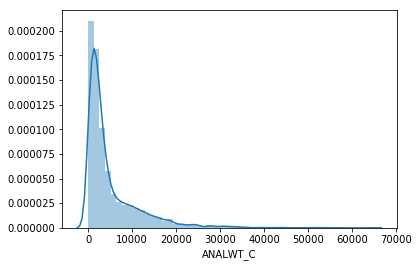

In [70]:
sns.distplot(train[train['Criminal']==1].ANALWT_C)

In [91]:
lr_model = LogisticRegression(C=100)
lr_model.fit(train_X,train_y)

val = lr_model.predict(train_X)
pred = lr_model.predict(test_X)


In [92]:
print(metrics.precision_recall_fscore_support(train_y, val, average='micro'))

(0.93505840150487773, 0.93505840150487773, 0.93505840150487773, None)
